In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

df = pd.read_csv('bank-additional-full.csv', delimiter=';')
df.rename(columns={
    'y': 'subscribed',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'euribor3m': 'euribor_3month_rate',
    'nr.employed': 'number_of_employees',
    'emp.var.rate': 'employment_variation_rate'
}, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3month_rate,number_of_employees,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Analysis

In [44]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        41188 non-null  int64  
 1   job                        41188 non-null  object 
 2   marital                    41188 non-null  object 
 3   education                  41188 non-null  object 
 4   default                    41188 non-null  object 
 5   housing                    41188 non-null  object 
 6   loan                       41188 non-null  object 
 7   contact                    41188 non-null  object 
 8   month                      41188 non-null  object 
 9   day_of_week                41188 non-null  object 
 10  duration                   41188 non-null  int64  
 11  campaign                   41188 non-null  int64  
 12  pdays                      41188 non-null  int64  
 13  previous                   41188 non-null  int

In [45]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'subscribed']

for column in categorical_columns:
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values in default: ['no' 'unknown' 'yes']
Unique values in housing: ['no' 'yes' 'unknown']
Unique values in loan: ['no' 'yes' 'unknown']
Unique values in contact: ['telephone' 'cellular']
Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Unique values in poutcome: ['nonexistent' 'failure' 'success']
Unique values in subscribed: ['no' 'yes']


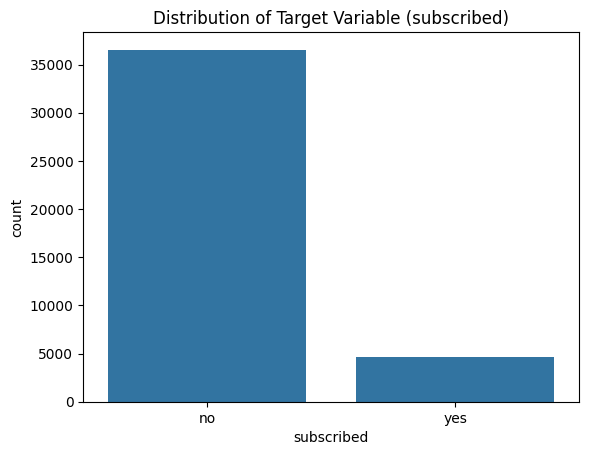

In [46]:
sns.countplot(x='subscribed', data=df)
plt.title('Distribution of Target Variable (subscribed)')
plt.show()

In [47]:
print(df['subscribed'].value_counts(normalize=True) * 100)

subscribed
no     88.734583
yes    11.265417
Name: proportion, dtype: float64


In [48]:
numerical_columns = ['employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index', 'euribor_3month_rate', 
                     'number_of_employees']

df[numerical_columns].describe()

,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3month_rate,number_of_employees
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,1.570960,0.578840,4.628198,1.734447,72.251528
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


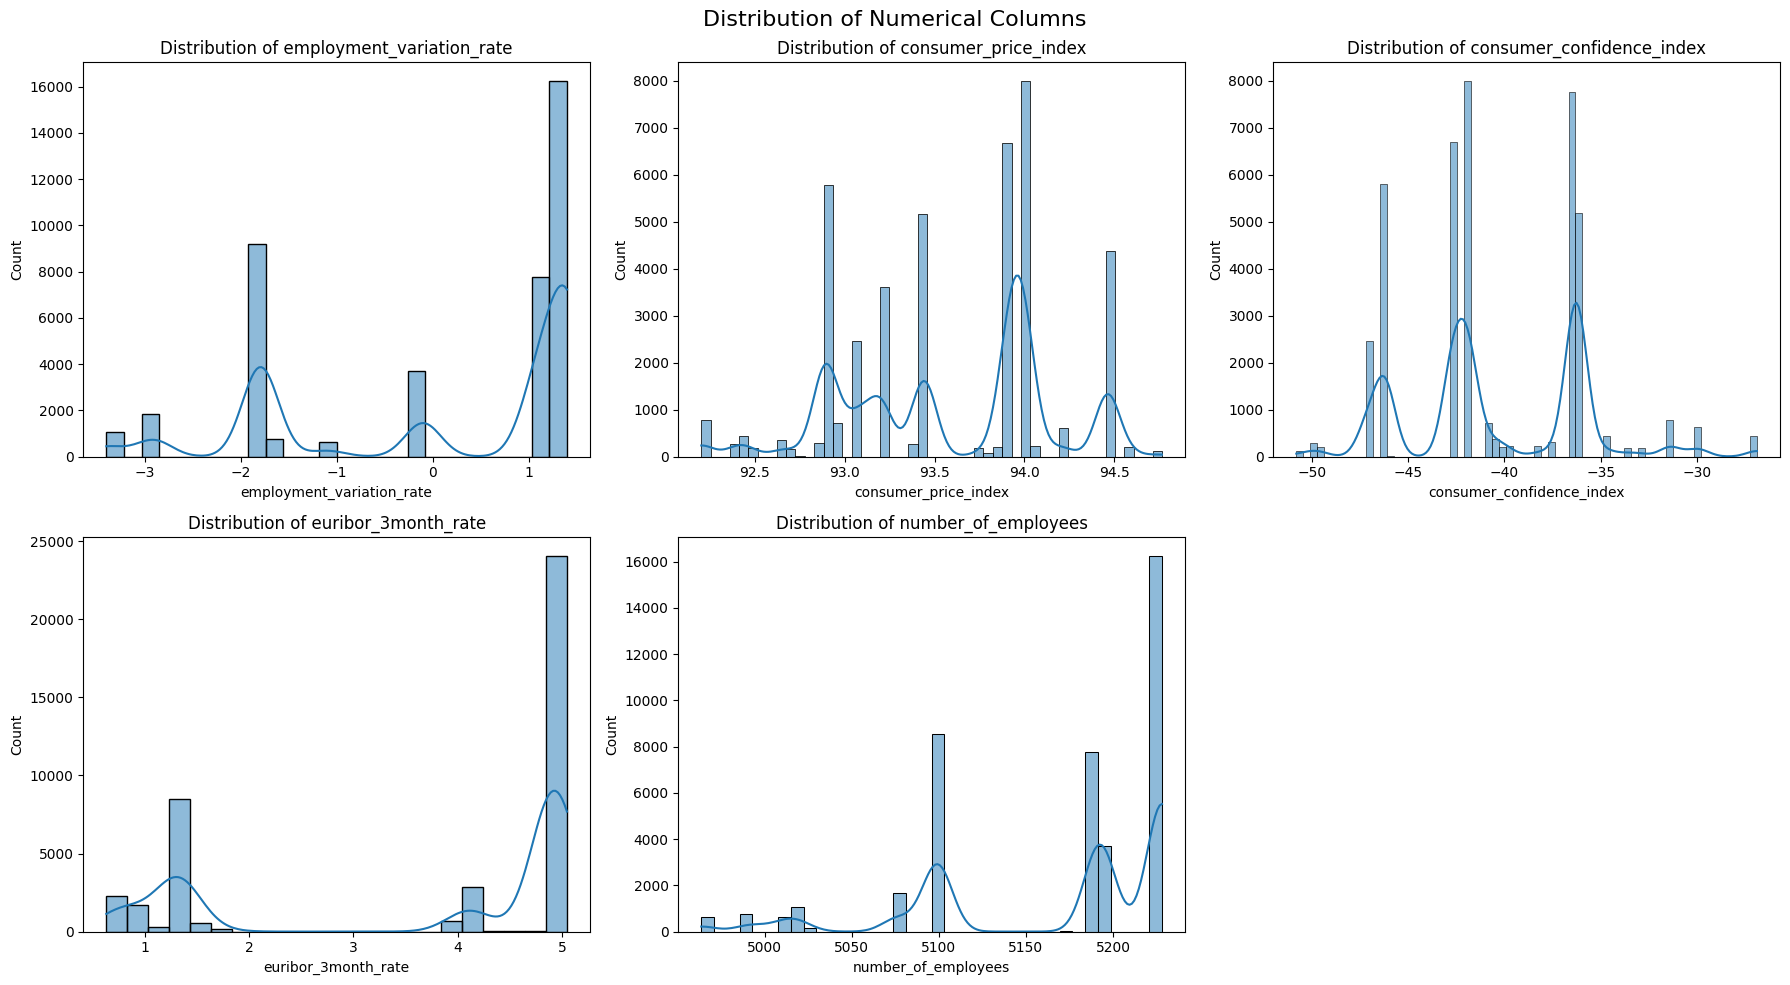

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, variable in enumerate(numerical_columns):
    row = i //3
    col = i % 3
    sns.histplot(df[variable], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {variable}')

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

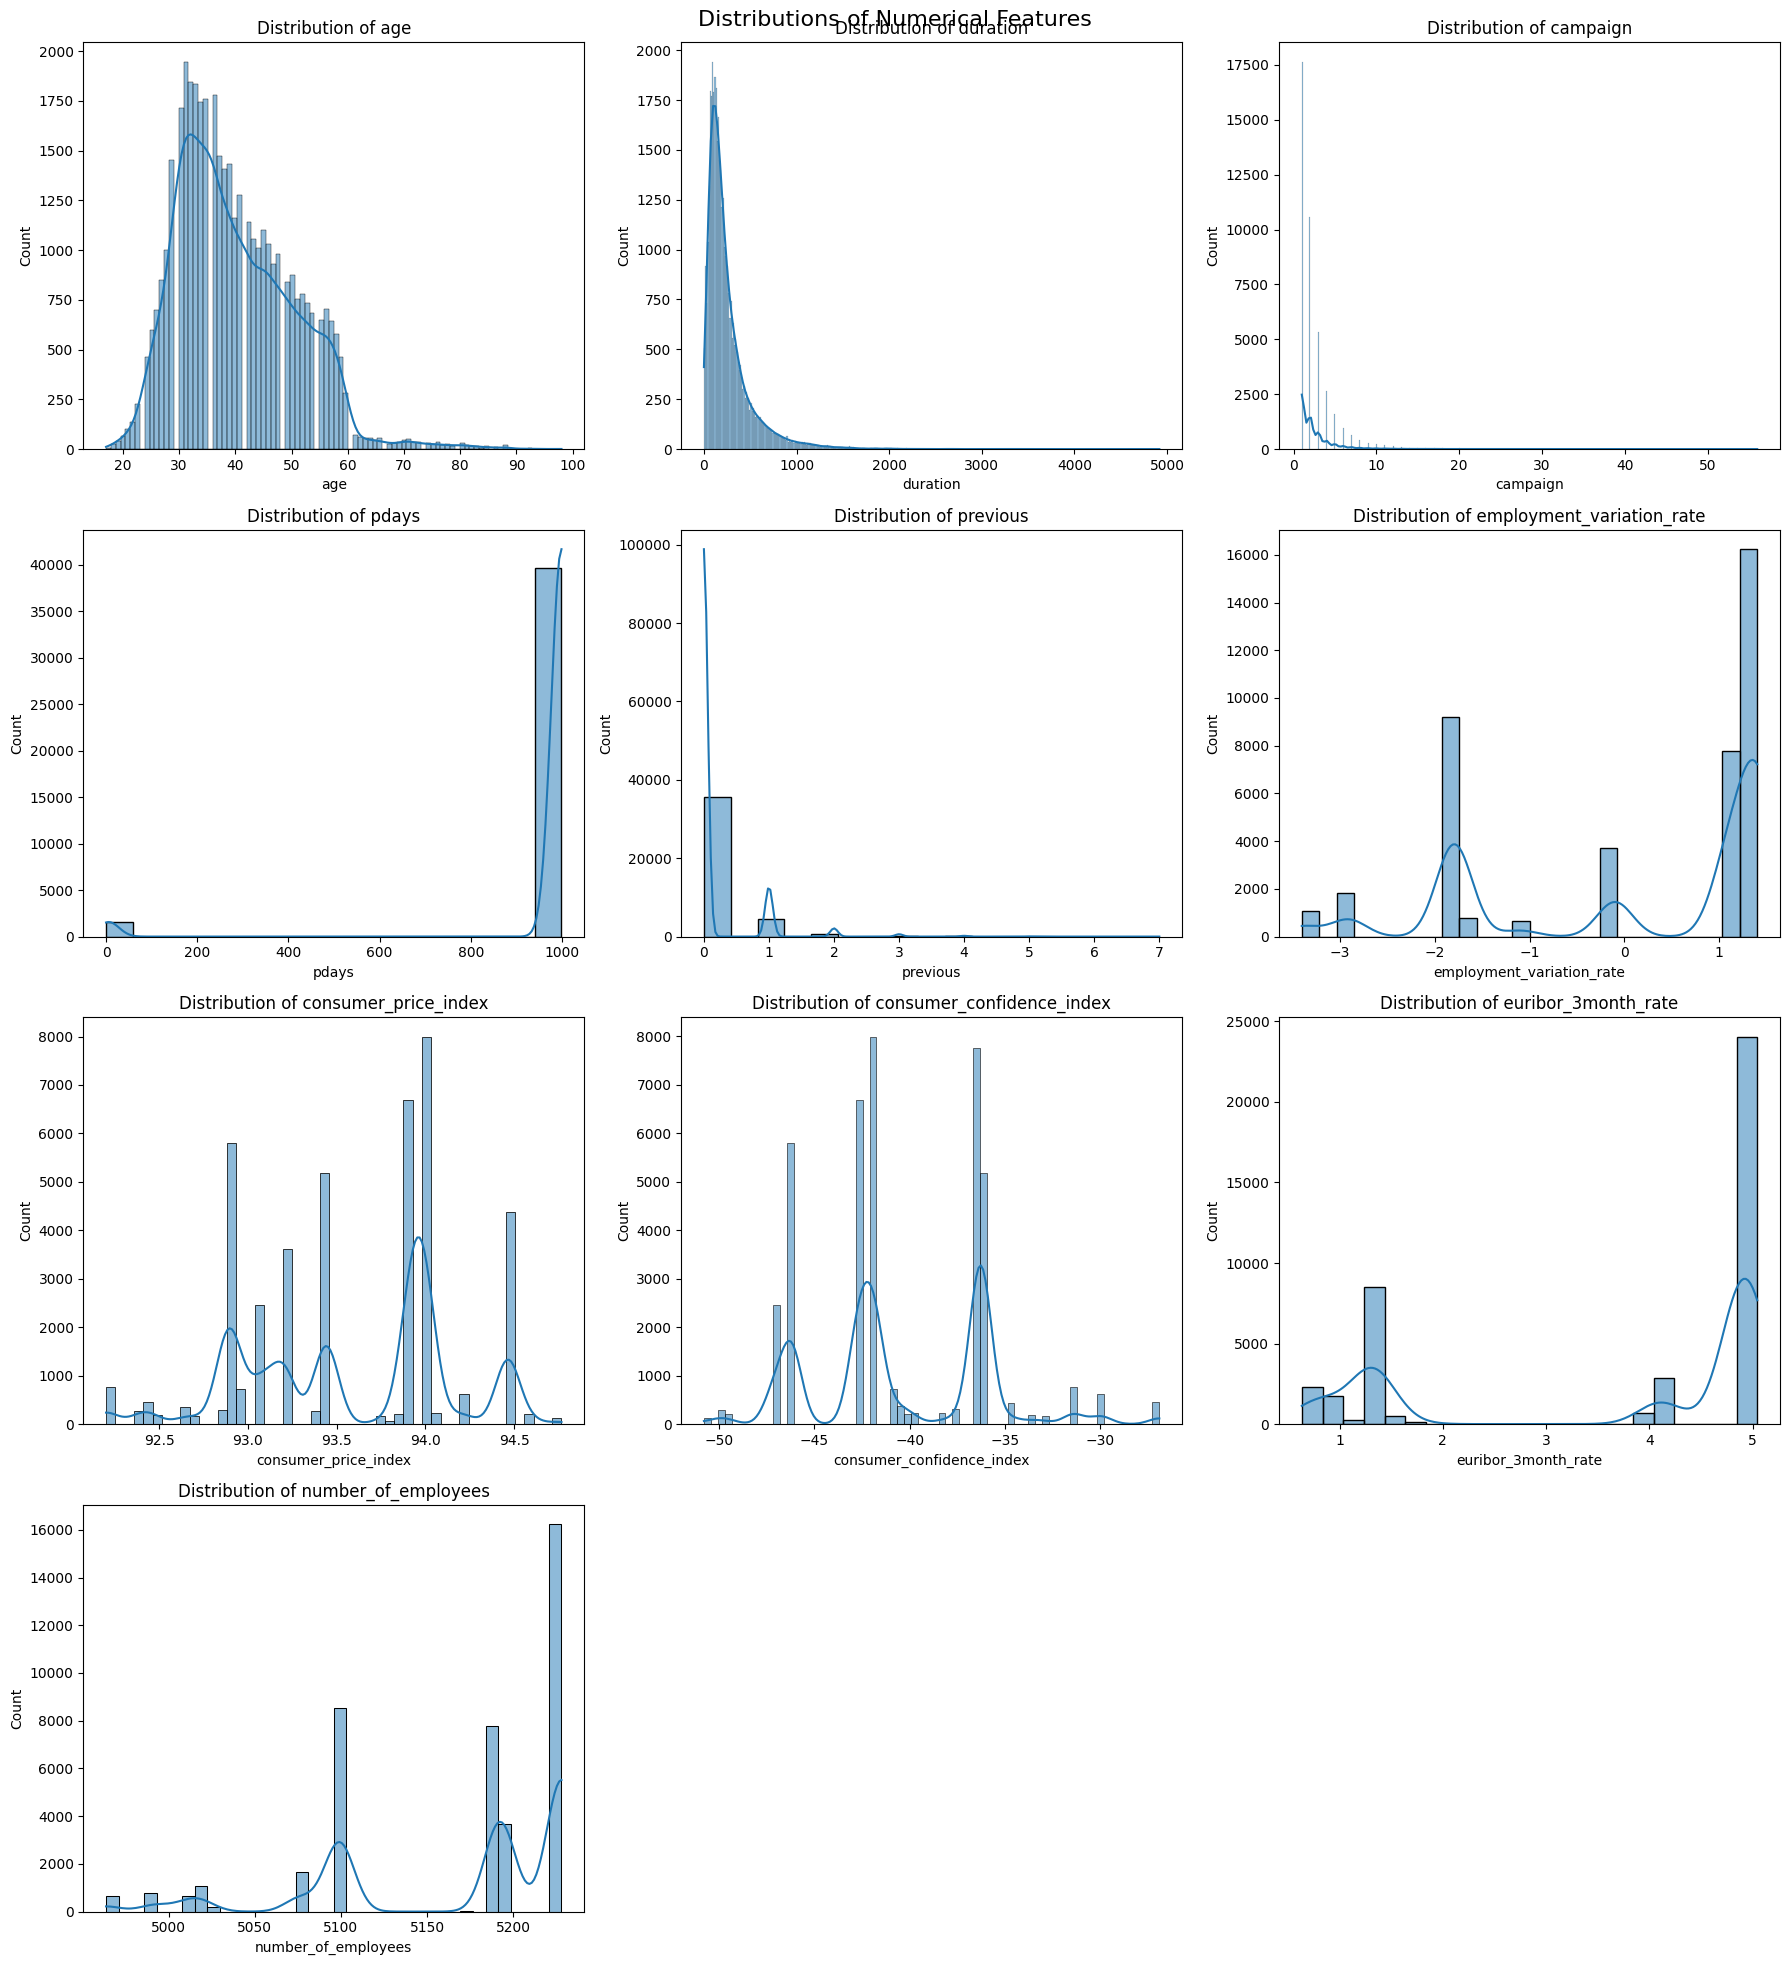

In [50]:
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous',
                      'employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index',
                      'euribor_3month_rate', 'number_of_employees']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
fig.suptitle('Distributions of Numerical Features', fontsize=16)

for i, feature in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')

for i in range(len(numerical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

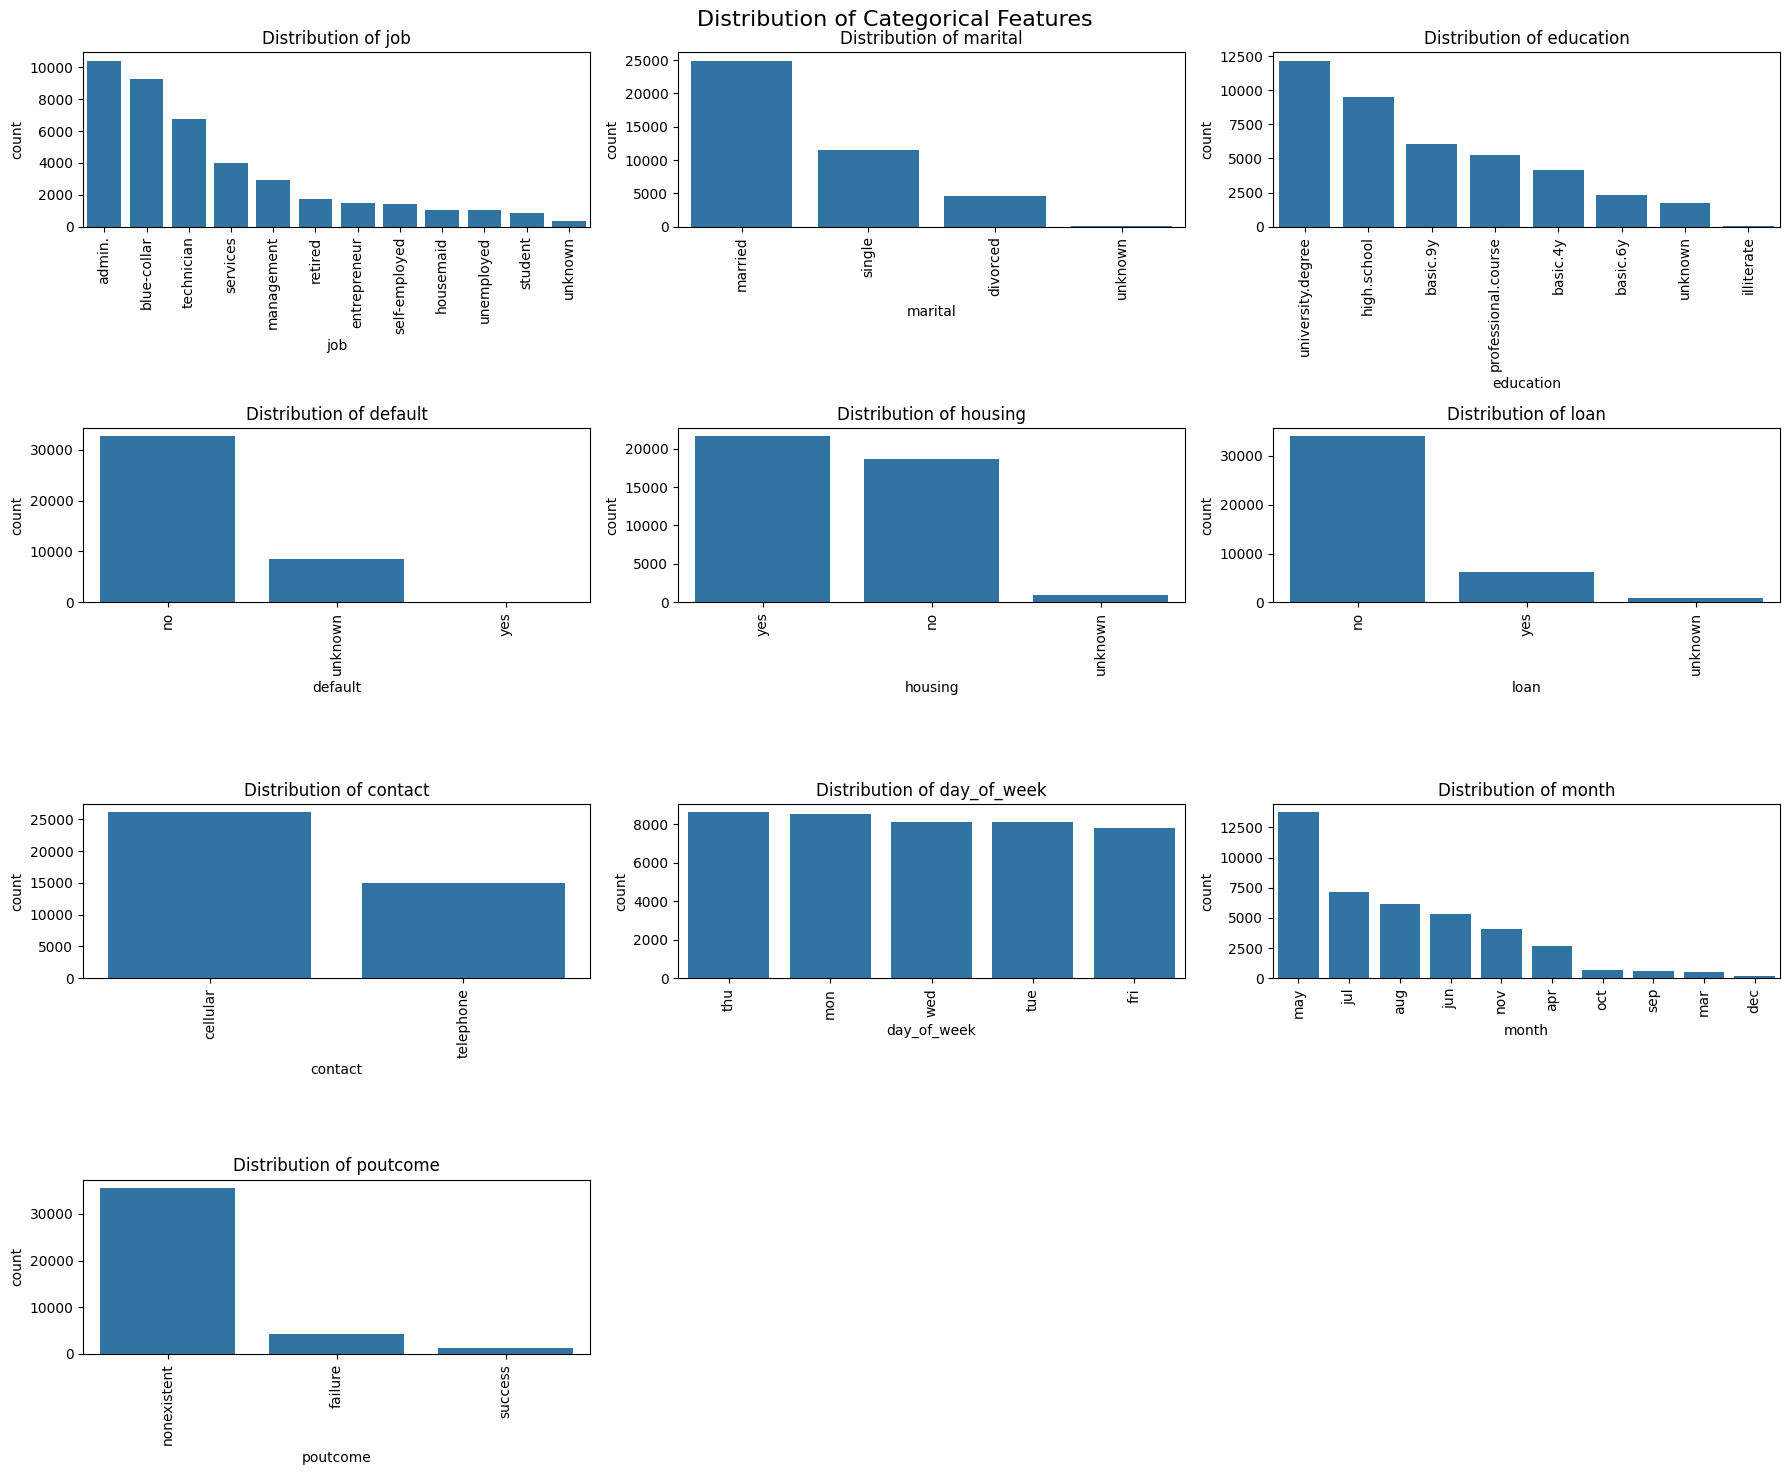

In [51]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'poutcome']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15))
fig.suptitle('Distribution of Categorical Features', fontsize=16)

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    sns.countplot(x=feature, data=df, ax=axes[row, col], order=df[feature].value_counts().index)
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].tick_params(axis='x', rotation=90)

for i in range(len(categorical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

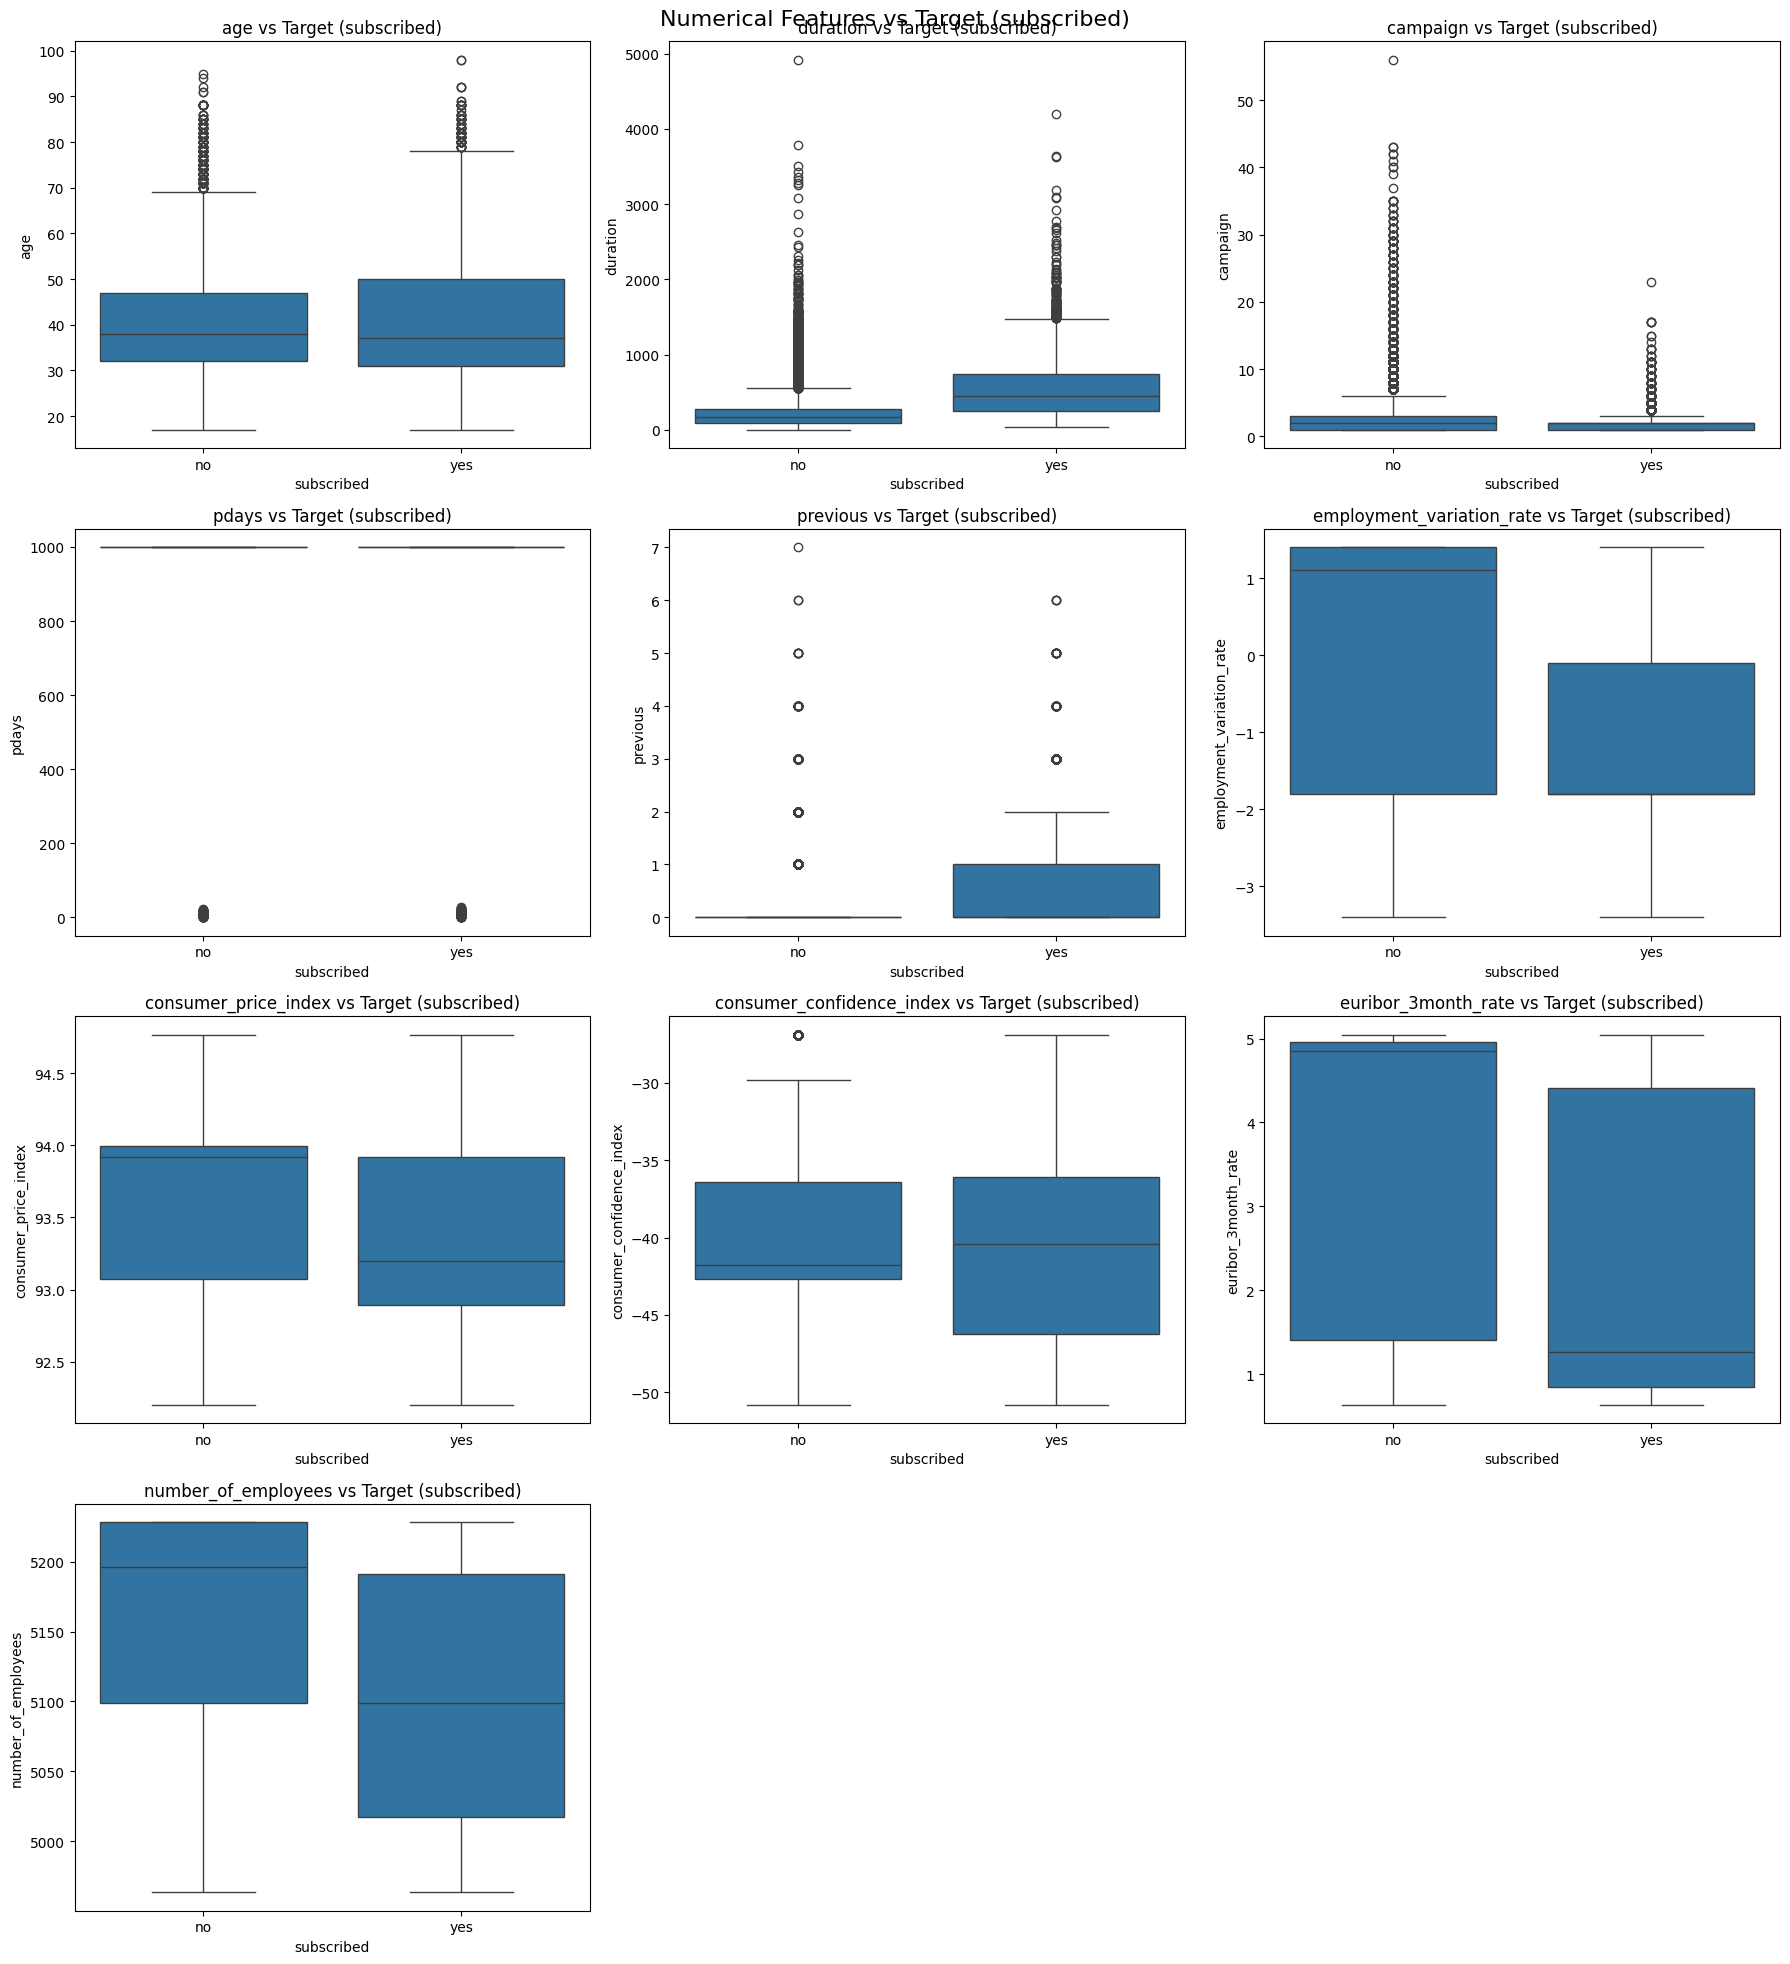

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
fig.suptitle('Numerical Features vs Target (subscribed)', fontsize=16)

for i, feature in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    sns.boxplot(x='subscribed', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs Target (subscribed)')

for i in range(len(numerical_features), 12):
    fig.delaxes(axes.flatten()[i])


plt.tight_layout()
plt.show()

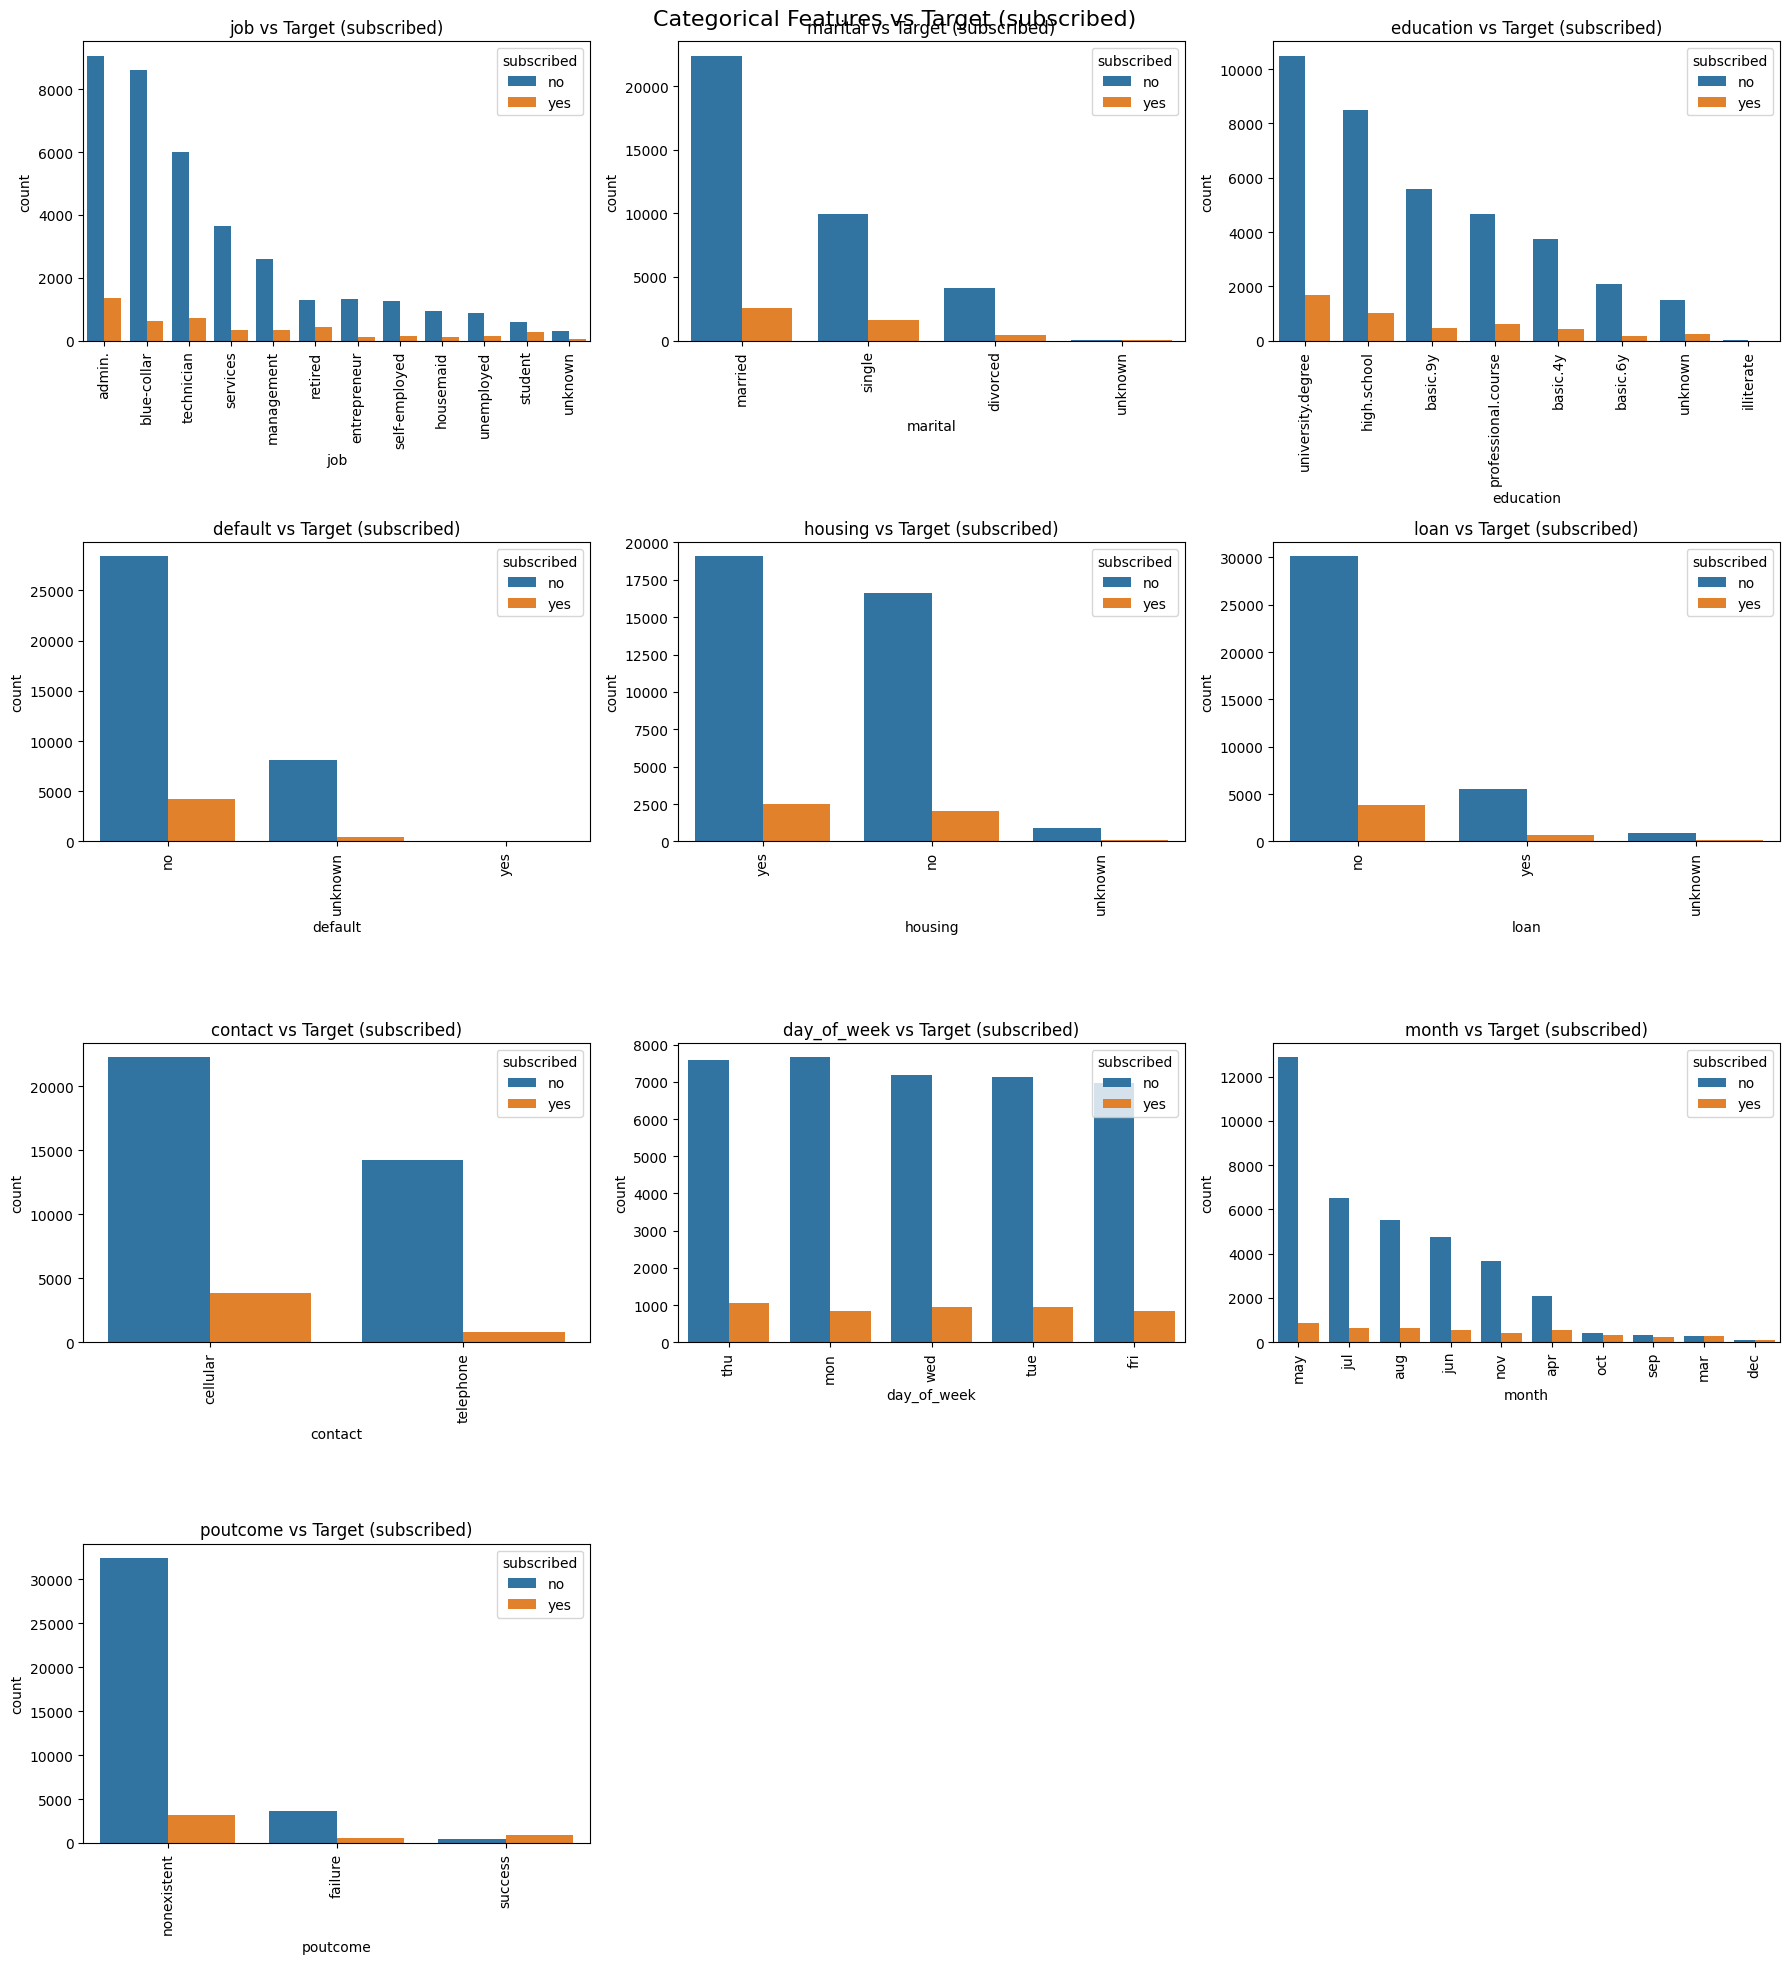

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18,20))
fig.suptitle('Categorical Features vs Target (subscribed)', fontsize=16)

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    sns.countplot(x=feature, hue='subscribed', data=df, ax=axes[row, col], order=df[feature].value_counts().index)
    axes[row, col].set_title(f'{feature} vs Target (subscribed)')
    axes[row, col].tick_params(axis='x', rotation=90)

for i in range(len(categorical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

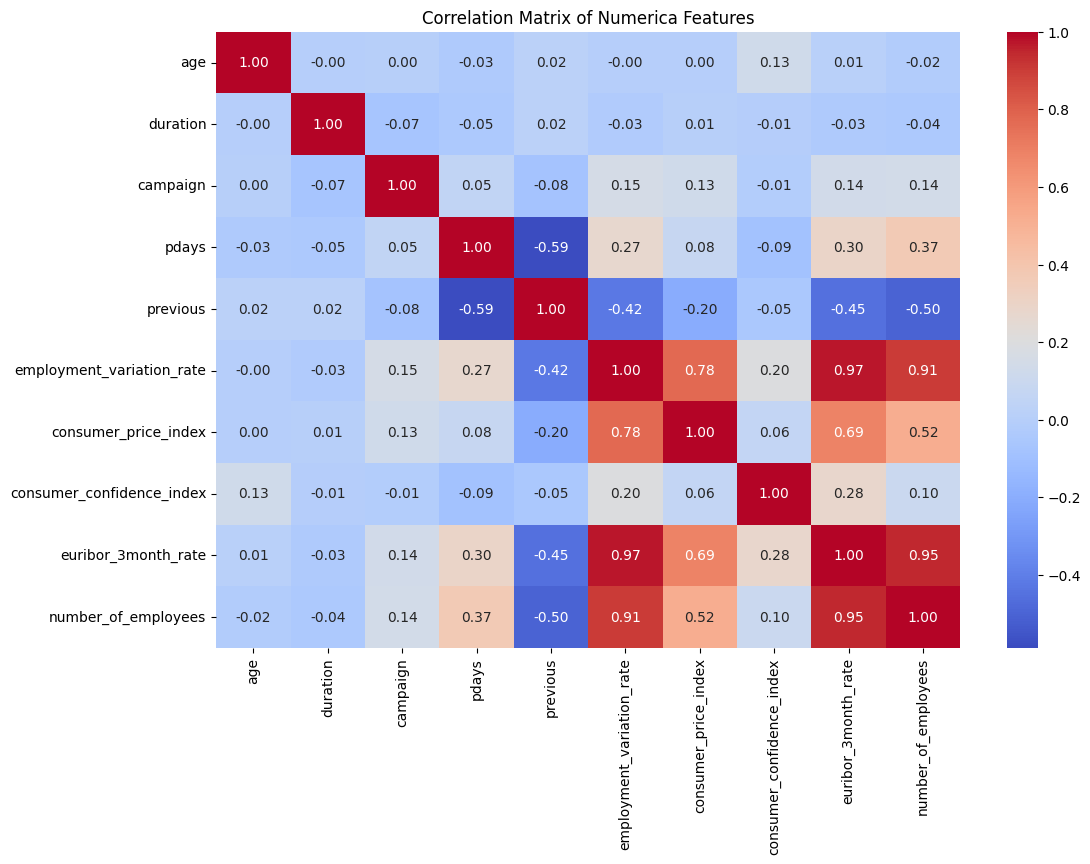

In [54]:
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerica Features')
plt.show()

## Data Preprocessing

In [55]:
# Drop highly correlated features
df = df.drop(['euribor_3month_rate', 'consumer_price_index'], axis=1)

In [56]:
# One-hot encode categorical features
categorical_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

pd.set_option('future.no_silent_downcasting', True)

# Binary encode binary features
binary_features = ['default', 'housing', 'loan']
df[binary_features] = df[binary_features].replace({'yes': 1, 'no': 0, 'unknown': 2}).astype(int)

In [57]:
# Scale numerical features
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'employment_variation_rate', 'number_of_employees']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [58]:
X = df.drop('subscribed', axis=1)
y = df['subscribed'].replace({'yes': 1, 'no': 0}).astype(int)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

subscribed
0    29245
1    29245
Name: count, dtype: int64


## Model Building

### Random Forest

In [61]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [64]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

/Users/josephdemcher/.pyenv/versions/3.11.5/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [66]:
best_rf_model = grid_search.best_estimator_

In [67]:
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

In [68]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [69]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC_AUC: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8985
Precision: 0.5429
Recall: 0.6695
F1-Score: 0.5996
ROC_AUC: 0.9370

Confusion Matrix:
[[6776  527]
 [ 309  626]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7303
           1       0.54      0.67      0.60       935

    accuracy                           0.90      8238
   macro avg       0.75      0.80      0.77      8238
weighted avg       0.91      0.90      0.90      8238

